In [1]:
from __future__ import division

import numpy as np
from wrf import getvar, get_basemap
from netCDF4 import Dataset
from itertools import product
import xarray as xr
from shapely.geometry import Point
import geopandas as gpd

In [21]:
#mask resolution
choice_res = 80

#import wrf domain
file2_wrf_d02 = '/glade/scratch/molina/WRF_HYSPLIT_proj/wrf4km_ens_2/wrfout_d01_2017-01-15_09:00:00'
ncfile2_wrf_d02 = Dataset(file2_wrf_d02)
dbz2_wrf_d02 = getvar(ncfile2_wrf_d02, "td2")
        
thecropper1 = 200
thecropper2 = 0
m = get_basemap(dbz2_wrf_d02[thecropper1:,thecropper2:])

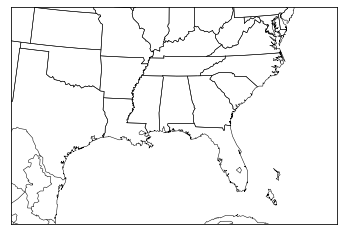

In [23]:
m.drawcoastlines(linewidth=0.5)
m.drawcountries()
m.drawstates()
plt.show()

In [24]:
#resolution of mask grid
xMax, yMax = m(m.urcrnrlon, m.urcrnrlat) 
xMin, yMin = m(m.llcrnrlon, m.llcrnrlat) 
x_range = (xMax-xMin) / 1000 
y_range = (yMax-yMin) / 1000 
numXGrids = round(x_range / choice_res + .5,0) 
numYGrids = round(y_range / choice_res + .5,0)
xi = np.linspace(xMin, xMax, int(numXGrids))
yi = np.linspace(yMin, yMax, int(numYGrids))  
x1, y1 = xi, yi

In [25]:
#shift the mask grid
x2 = np.zeros(x1.shape)
y2 = np.zeros(y1.shape)
x3 = np.zeros(x1.shape)
y3 = np.zeros(y1.shape)
for i, j in product(range(len(x1)),range(len(y1))):
    x2[i], y2[j] = m(x1[i], y1[j], inverse=True)
    x2[i] = x2[i]-0.4
    y2[j] = y2[j]-0.4
    x3[i], y3[j] = m(x2[i], y2[j])
#omit first
x4, y4 = x3[1:], y3[1:]
#convert
m_lon, m_lat = m(*np.meshgrid(x4, y4), inverse=True)

In [26]:
#export CONUS
can = gpd.GeoDataFrame.from_file("/glade/work/molina/DATA/usstates_shapefiles/tl_2017_us_state.shp")
#create the mask full of boolean (false)
the_mask = np.full((y4.shape[0], x4.shape[0]), False)

In [27]:
#loop through identifying land mask or not
for v, b in product(range(y4.shape[0]),range(x4.shape[0])):
    for c in can.index.values:
        canned = can.loc[c]
        if canned.geometry.contains(Point(m_lon[v,b], m_lat[v,b])):
            the_mask[v,b] = True
            continue

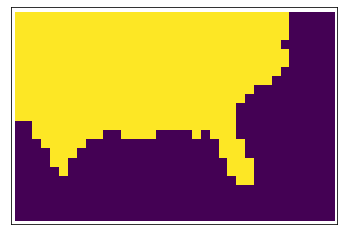

In [28]:
import matplotlib.pyplot as plt
m.pcolormesh(x4,y4, the_mask);plt.show()

In [29]:
#create and save mask
project_mask = xr.Dataset({'conus':(['y','x'],the_mask)},
                          coords={'lat_deg':(['y','x'],m_lat),
                                  'lon_deg':(['y','x'],m_lon)},
                           attrs={'File Author':'Maria J. Molina'})
project_mask.to_netcdf('/glade/work/molina/DATA/usstates_shapefiles/newconus_mask_res_'+str(choice_res)+'.nc')

KeyboardInterrupt: 

In [30]:
project_mask

<xarray.Dataset>
Dimensions:  (x: 37, y: 24)
Coordinates:
    lat_deg  (y, x) float64 22.05 22.14 22.22 22.29 ... 39.66 39.58 39.48 39.38
    lon_deg  (y, x) float64 -101.4 -100.6 -99.83 -99.03 ... -71.69 -70.75 -69.82
Dimensions without coordinates: x, y
Data variables:
    conus    (y, x) bool False False False False ... False False False False
Attributes:
    File Author:  Maria J. Molina

In [31]:
project_mask.to_netcdf('/glade/work/molina/DATA/usstates_shapefiles/newconus_mask_res_80.nc')